# <center><strong>Natural Language Processing dan Text Mining</strong></center>
    
## <center><strong><font color="blue">UDA-08: Topic Modelling</font></strong></center>
<img alt="" src="images/SocMed.png" style="height: 171px; width: 600px;" /> 
    
## <center>(C) Taufik Sutanto - 2020 </center>

## <font color="blue">Outline Topic Modelling :</font>

* Importing Data
* Pendahuluan Topic Modelling
* Soft Clustering (Topic Modelling): LDA dan NMF
* Visualisasi dan Interpretasi

In [ ]:
# Jalankan Cell ini "HANYA" jika anda menggunakan Google Colab
# Jika di jalankan di komputer local, silahkan lihat NLPTM-02 untuk instalasinya.
import warnings; warnings.simplefilter('ignore')
import nltk

!wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/taudataNlpTm.py
!mkdir data
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/slang.txt
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_id.txt
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_en.txt
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/kata_dasar.txt
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-ind-def.tab
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-msa-all.tab
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/ind_SA.csv
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/all_indo_man_tag_corpus_model.crf.tagger

!pip install spacy python-crfsuite unidecode textblob sastrawi
!python -m spacy download en
!python -m spacy download xx
!python -m spacy download en_core_web_sm

nltk.download('popular')

In [1]:
# Importing Modules untuk Notebook ini
import warnings; warnings.simplefilter('ignore')
import taudataNlpTm as tau, itertools, re, pickle, pyLDAvis, pyLDAvis.sklearn, spacy, urllib.request
import time, numpy as np, matplotlib.pyplot as plt, networkx as nx, pandas as pd, seaborn as sns 
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tag import CRFTagger
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from gensim.models import Word2Vec, FastText
import tweepy, json, nltk, urllib.request, requests
from urllib.request import Request, urlopen
from twython import TwythonStreamer
from bs4 import BeautifulSoup as bs

pyLDAvis.enable_notebook()
sns.set(style="ticks", color_codes=True)
random_state = 99
'Done'

c:\winpython\python-3.6.8.amd64\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


'Done'

# Kita Awali dengan pengambilan data paling up-to-date 

In [11]:
# Contoh API Keys (Sesuaikan dengan API keys masing-masing)
Ck = '' # consumer_key
Cs = '' # consumer_secret
At = '-' # utaccess_token
As = '' # access_secret
'Done'

'Done'

In [14]:
def twitter_connect(Ck, Cs, At, As, verbose = 0):
    try:
        auth = tweepy.OAuthHandler(Ck, Cs)
        auth.set_access_token(At, As)
        twitter = tweepy.API(auth, timeout=120)
        if verbose != 0:
            user = twitter.verify_credentials()
            print('Welcome "%s" you are now connected to twitter server' %user.name)
        return twitter
    except Exception as err_:
        print("Connection failed: ", err_)
        return None

In [17]:
# Koneksi ke twitter
twitter = twitter_connect(Ck, Cs, At, As, verbose = 1)

Welcome "Taufik Sutanto" you are now connected to twitter server


In [18]:
# Max 100 tweet per "API call"
topic = 'vaksin covid indonesia'
N = 100 # jumlah tweet yang ingin diambil
bahasa = 'id'
T = twitter.search(q=topic, lang=bahasa, count=N, tweet_mode = 'extended')
tweets = [t._json for t in T]
print(' Berhasil mendapatkan {} tweets'.format(len(tweets)))

 Berhasil mendapatkan 100 tweets


In [29]:
last_id = T[-1]._json['id'] - 1
T = twitter.search(q=topic, lang=bahasa, count=N, tweet_mode = 'extended', max_id=last_id)
tweets.extend([t._json for t in T])
print('Jumlah data sekarang = ', len(tweets))

Jumlah data sekarang =  1144


In [30]:
f = open('data/contoh_Tweet_covid_vaksin_Indonesia_09122020.pckl', 'wb')
pickle.dump(tweets, f)
f.close()

In [2]:
try:
    f = open('data/contoh_Tweet_covid_vaksin_Indonesia_09122020.pckl', 'rb')
    tweets = pickle.load(f)
    f.close()
except:
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/contoh_Tweet_covid_vaksin_Indonesia_09122020.pckl
    f = open('data/contoh_Tweet_covid_vaksin_Indonesia_09122020.pckl', 'rb')
    tweets = pickle.load(f)
    f.close()

print(len(tweets))

1144


# Preprocess Data

In [3]:
D = [t['full_text'] for t in tweets] # Tweet hasil crawling
D[0]

'RT @sociotalker: OK gaezz...i’m officially leading this initiative!\n\nkita harus menuntut pemerintah memberikan vaksin covid ke semua orang…'

In [4]:
stops, lemmatizer = tau.LoadStopWords(lang='id')
stops.add('rt'); stops.add('..')
for i,d in tqdm(enumerate(D)):
    D[i] = tau.cleanText(d, lemma=lemmatizer, stops = stops, symbols_remove = True, min_charLen = 2)
    
print(D[0])

1144it [00:01, 717.39it/s]

sociotalker ok gaezz officially leading this initiative menuntut pemerintah vaksin covid orang


<h3>Ketika mengolah dokumen (file dalam bentuk teks), harapan kita seperti ini:</h3>

<img alt="" src="images/4_harapan_LSA.png" style="height:99px; width:198px" />


<h3>Namun kita sudah bahas kemarin kenyataannya seperti ini:</h3>

<p><img alt="" src="images/4_kenyataan_LSA.png" style="height:183px; width:182px" /></p>

<h2 id="Topic-Modelling-1-:-Latent-Dirichlet-Allocation">Topic Modelling 1 : Latent Dirichlet Allocation</h2>

<p><img alt="" src="images/4_Document_to_Topics.png" style="height: 300px ; width: 582px" /></p>

<p><strong><big>Tapi bukan seperti klasifikasi dan bukan berarti kata-kata Sport, Technology, dan Entertainment dominan di kategori-kategori tersebut. Topic modelling lebih ke soft-clustering, dimana suatu dokumen dimasukkan ke dalam beberapa cluster (topic) sekaligus. Adapun nama &quot;topic/cluster&quot;-nya di interpretasi dari kata-kata yang ada didalamnya.</big></strong></p>


<p><img alt="" src="images/4_LDA vs LDA.JPG" style="height:400px; width:606px" /></p>
[<a href="http://chdoig.github.io/pytexas2015-topic-modeling/" target="_blank">Sumber gambar ini dan beberapa gambar selanjutnya</a>]</p>

<p><img alt="" src="images/4_definisi topic model.JPG" style="height:350px; width:809px" />


<p><img alt="" src="images/4_inti_LDA.JPG" style="height:500px; width:785px" /></p>
Penjelasan intuitif yang baik: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d 

<h3>Evaluasi LDA?</h3>

<p><img alt="" src="images/4_Evaluasi_LDA.jpg" style="height:400px; width:888px" /></p>
[Cara lain: http://mimno.infosci.cornell.edu/slides/details.pdf]

<p><img alt="" src="images/4_LDA Pipeline.JPG" style="height:300px; width:663px" /></p>
* Modifikasi dapat dilakukan dengan "pos tags"

In [5]:
# Kita mulai dengan membuat VSM-nya
# kita gunakan perintah yang ada di Segmen sebelumnya 
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer()

data = D.copy()
tf = tf_vectorizer.fit_transform(data)
tf_terms = tf_vectorizer.get_feature_names()
# Mengapa tf bukan tfidf?
# Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
# Bisa di tamahkan dengan Frequency filtering "Max_df" dan "Min_df"

tf.shape

(1144, 1129)

In [6]:
# Dilanjutkan dengan membentuk model LDA-nya
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_topics = 3 # Misal tidak di optimalkan terlebih dahulu
lda = LDA(n_components=n_topics, learning_method='batch', random_state=0).fit(tf)   
lda

LatentDirichletAllocation(n_components=3, random_state=0)

In [7]:
# Melihat Topik-topiknya
vsm_topics = lda.transform(tf)
print(vsm_topics.shape)
vsm_topics
# Ukuran kolom = #Topics ==> Dimension Reduction
# Mengapa tidak dibagi Train & Test???

(1144, 3)


array([[0.94722897, 0.02605476, 0.02671627],
       [0.77923504, 0.02236493, 0.19840002],
       [0.94722897, 0.02605476, 0.02671627],
       ...,
       [0.67000854, 0.01263382, 0.31735764],
       [0.77923504, 0.02236493, 0.19840002],
       [0.77923504, 0.02236493, 0.19840002]])

In [8]:
# "Seandainya" diasumsikan 1 dokumen hanya 1 topic dengan nilai skor topic terbesar
doc_topic =  [a.argmax()+1 for a in tqdm(vsm_topics)] # topic of docs
doc_topic[:10]

100%|██████████████████████████████████████████████████████████████████████████| 1144/1144 [00:00<00:00, 452156.41it/s]


[1, 1, 1, 1, 3, 1, 1, 1, 1, 1]

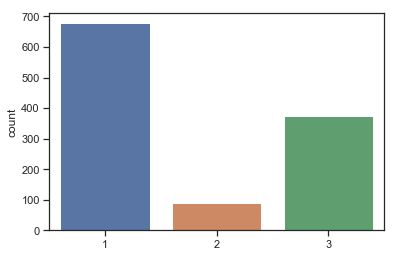

In [9]:
# mari kita plot
plot = sns.countplot(doc_topic)

In [10]:
# Mari kita coba maknai masing-masing topic ini
Top_Words = 15
print('Printing top {0} Topics, with top {1} Words:'.format(n_topics, Top_Words))
tau.print_Topics(lda, tf_terms, n_topics, Top_Words)

Printing top 3 Topics, with top 15 Words:
Topic #1:
vaksin covid orang pemerintah this leading gaezz ok officially menuntut initiative sociotalker masyarakat izin bpom
Topic #2:
vaksin indonesia covid 19 masyarakat kedatangan datangnya direksi negara produk gelombang sinovac segar angin vaksinasi
Topic #3:
vaksin 19 indonesia covid gotong royong juta sinovac pemerintah dosis bertahap pengadaan kedatangan direksi menanggulangi


In [11]:
# %matplotlib inline
# Mari kita Plot, supaya lebih jelas
# Catatan, bergantung dari laptop yang digunakan, image terkadang cukup lama untuk muncul.
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)  

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.313548  0.006273       1        1  55.146792
2     -0.145107 -0.129579       2        1  33.871346
1     -0.168440  0.123306       3        1  10.981863, topic_info=            Term        Freq       Total Category  logprob  loglift
397    indonesia  468.000000  468.000000  Default  30.0000  30.0000
6             19  462.000000  462.000000  Default  29.0000  29.0000
758        orang  382.000000  382.000000  Default  28.0000  28.0000
1048        this  371.000000  371.000000  Default  27.0000  27.0000
564      leading  370.000000  370.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
474   kedatangan   15.530021   48.440292   Topic3  -4.6221   1.0714
249      direksi   14.613697   46.578863   Topic3  -4.6829   1.0497
605   masyarakat   22.058807  232.120499   Topic3  -4.2712  -0.1446
971      sinovac   12.982691  104.451752   Topic3  -4.8013   0.1238
450         juta    9.693084  103.537004   Topic3  -5.0935  -0.1596

[155 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3         2  0.974317       12
6         1  0.002161       19
6         2  0.903476       19
6         3  0.095103       19
11        2  0.911270     2020
...     ...       ...      ...
1101      1  0.995455  vice_id
1110      3  0.911701    warga
1114      3  0.969738       wi
1124      2  0.727026       yg
1124      3  0.276962       yg

[143 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

# Bagaimana jika kita ingin menggunakan semi-supervised (guided) LDA?
https://medium.freecodecamp.org/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164 

# Bagaimana melakukan Post-Tag sebelum Topic Modelling?

In [12]:
from spacy.lang.id import Indonesian
from nltk.tag import CRFTagger
nlp_id = Indonesian()  # Language Model
ct = CRFTagger()
ct.set_model_file('data/all_indo_man_tag_corpus_model.crf.tagger')

def NLPfilter(t, filters):
    tokens = nlp_id(t)
    tokens = [str(k) for k in tokens if len(k)>2]
    hasil = ct.tag_sents([tokens])
    return [k[0] for k in hasil[0] if k[1] in filters]

In [13]:
filters = set(['NN', 'NNP', 'NNS', 'NNPS', 'JJ'])

for i, d in tqdm(enumerate(data)):
    data[i] = NLPfilter(d,filters)

' '.join(data[0])

1144it [00:01, 1133.64it/s]


'pemerintah vaksin covid orang'

In [14]:
print(data[:3])

[['pemerintah', 'vaksin', 'covid', 'orang'], ['rodrichen', 'komen', 'indonesia', 'penanganan', 'salah', 'alat'], ['pemerintah', 'vaksin', 'covid', 'orang']]


# Evaluasi: Bagaimana mendapatkan parameter Optimal Topic Modelling?

**Beberapa catatan penting**:
1. Hati-hati Struktur Data, untuk melakukan evaluasi Topic Modelling struktur data yang digunakan mirip dengan Word Embedding.
2. Kita akan melakukan cross-validasi dan N-Gram
3. Ada berbagai metric evaluasi https://radimrehurek.com/gensim/models/coherencemodel.html
4. Referensi paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [17]:
bigram_t = Phrases(data, min_count=2)
trigram_t = Phrases(bigram_t[data])
for idx, d in enumerate(data):
    for token in bigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data[idx].append(token)
    for token in trigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data[idx].append(token)

# Create a dictionary representation of the documents.
# Remove rare & common tokens
dictionary_t = Dictionary(data)
dictionary_t.filter_extremes(no_below=2, no_above=0.9)
#Create dictionary and corpus required for Topic Modeling
corpus_t = [dictionary_t.doc2bow(doc) for doc in data]
print('Number of unique tokens: %d' % len(dictionary_t))
print('Number of documents: %d' % len(corpus_t))
print(corpus_t[:1])

Number of unique tokens: 486
Number of documents: 1144
[[(0, 1), (1, 1), (2, 1)]]


In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, coherence='c_v', start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Caution cell berikut ini membutuhkan waktu yang cukup signifikan untuk selesai, karena selain LDA *computationally expensive* loopingnya juga melakukan Cross-validasi di setiap jumlah topik *k*

In [23]:
start, step, limit = 2, 1, 10 # Ganti dengan berapa banyak Topic yang ingin di hitung/explore
coh_t, kCV = [], 10 # hati-hati sangat LAMBAT karena cross validation pada metode yang memang tidak efisien (LDA)

print('iterasi ke: ', end = ' ')
for i in range(kCV):
    print(i+1, end = ', ', flush=True)
    model_list, c = compute_coherence_values(dictionary=dictionary_t, corpus=corpus_t, texts=data, start=start, limit=limit, step=step)
    coh_t.append(c)
    
coherence_t = np.mean(np.array(coh_t), axis=0)
'Done'

iterasi ke:  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

'Done'

c:\winpython\python-3.6.8.amd64\lib\site-packages\matplotlib\legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002A0BF3784A8> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


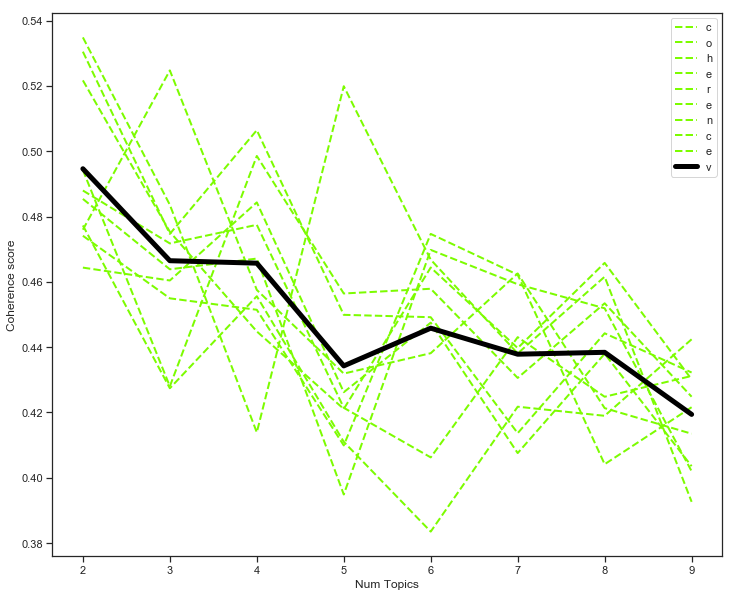

In [24]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(12,10))
for c in coh_t:
    plt.plot(x, c, '--', color = 'lawngreen', linewidth = 2)
plt.plot(x, coherence_t, '-', color = 'black', linewidth = 5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Referensi Pilihan:

* perhitungan Manual Topic Modelling LDA: http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/
* http://mimno.infosci.cornell.edu/slides/details.pdf
* https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
* http://www.umiacs.umd.edu/~jbg/docs/nips2009-rtl.pdf
* http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
* Penjelasan intuitif yang baik: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d 
* inconjunction dengan interactive program berikut: https://lettier.com/projects/lda-topic-modeling/ 

## Non-Negative Matrix Decomposition (NMF)

<img alt="" src="images/4_NMF.jpg" /> 
    
* image source: https://www.slideshare.net/SebastianRuder/dynamic-topic-modeling-via-nonnegative-matrix-factorization-dr-derek-greene

<img alt="" src="images/NMF_Opt_1.png" />

<h3 id="Tujuan-NMF:">Tujuan NMF:</h3>

<p><img alt="" src="images/4_NMF_Goal.JPG" style="height: 363px; width: 600px;" /></p>


In [28]:
# Langsung Aplikasi-nya
# Perhatikan NMF bisa menggunakan Float
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

data = D.copy()

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(data)
nmf_model = NMF(n_components = 3, random_state=0)
nmf = nmf_model.fit(tfidf)

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tau.print_Topics(nmf, tfidf_feature_names, n_topics, Top_Words)


Topics in NMF model:
Topic #1:
this leading ok menuntut initiative gaezz officially sociotalker orang pemerintah covid vaksin janji 19 menanggulangi
Topic #2:
terawan mengklaim miskin membayar mandi menkes darurat vice_id izin bpom masyarakat vaksin direksi 19 indonesia
Topic #3:
indonesia 19 vaksin royong gotong hny covid bertahap penanganan salah menggantungkan na rodrichen komen alat


In [29]:
# Sama seperti LDA kita bisa melihat distribusi topic setiap dokumen
vsm_topics = nmf.transform(tfidf)
vsm_topics[:10]

array([[0.22339384, 0.        , 0.        ],
       [0.        , 0.        , 0.22681493],
       [0.22339384, 0.        , 0.        ],
       [0.22339384, 0.        , 0.        ],
       [0.00252443, 0.0016436 , 0.01881803],
       [0.22339384, 0.        , 0.        ],
       [0.22339384, 0.        , 0.        ],
       [0.22339384, 0.        , 0.        ],
       [0.22339384, 0.        , 0.        ],
       [0.22339384, 0.        , 0.        ]])

100%|██████████████████████████████████████████████████████████████████████████| 1144/1144 [00:00<00:00, 382577.24it/s]

In total there are 3 major topics, distributed as follows


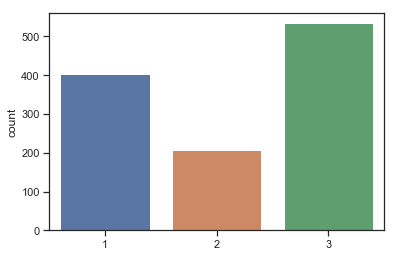

In [30]:
# Seandainya diasumsikan 1 dokumen hanya 1 topic dengan nilai skor topic terbesar
doc_topic =  [a.argmax()+1 for a in tqdm(vsm_topics)] # topic of docs
print('In total there are {0} major topics, distributed as follows'.format(len(set(doc_topic))))
sns.countplot(doc_topic)
plt.show()

# Latihan :

* Load data data tweet dengan isu berbeda.
* Lakukan preprocessing (termasuk lemma) dan pos tag (ambil hanya noun saja)
* Bandingkan hasil topic dari LDA, dan NMF dari data tersebut.
* Apakah hasilnya sudah baik?
* Buat visualisasi pyLDAvis-nya dan analisa lebih lanjut.

# End of Module

<hr />
<img alt="" src="images/ " />